In [1]:
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

import torch
from torch import nn
torch.__version__

import matplotlib.pyplot as plt

In [2]:
if torch.backends.mps.is_available(): # MPS device acceleration [For Macbook M1]
    device= "mps"
elif torch.cuda.is_available(): # use GPU, if exists
    device = "cuda"
else:
    device = "cpu"
print(device)

mps


In [3]:
def set_seed(seed):
    if device == "mps":
        torch.mps.manual_seed(seed)
    elif device == "cuda":
        torch.cuda.manual_seed(seed)
    else:
        torch.manual_seed(seed)

# accuracy: TP / (TP + FP) * 100%
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100
    return acc


In [4]:
# create sample dataset
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

# turn into proper data type for PyTorch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


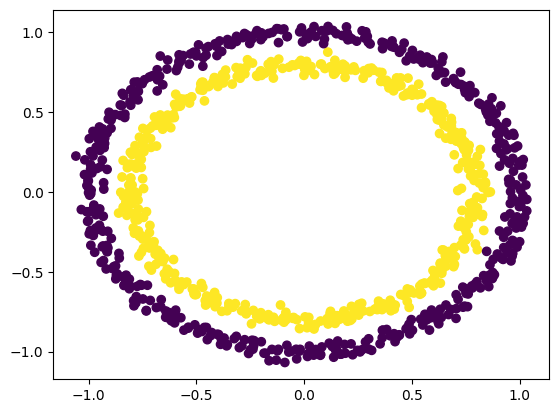

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y)

### Linear Model

In [6]:
# inherit nn.Module and create a new class: MyModelV0
class MyModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layers = nn.Sequential(
                                nn.Linear(in_features=2, out_features=5), # 2 nodes -> 5 hidden units
                                nn.Linear(in_features=5, out_features=1)  # 5 hidden units -> 1 output node
                            )
    
    def forward(self, x):
        return self.linear_layers(x)
    
# create instance and put to related device
model_0 = MyModelV0().to(device)

# setup loss function
loss_fn = nn.BCEWithLogitsLoss() # Binary Cross Entropy with Logit * Note - build in with sigmoid activation function

# setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1) # by using SGD, update the param of model_0 during training 

# put data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

set_seed(42)
epochs = 100

# train model
for epoch in range(epochs):
    model_0.train() # train
    y_logits = model_0(X_train).squeeze() # forward pass
    
    y_pred = torch.round(torch.sigmoid(y_logits)) # transform logits -> prediction probability -> labels; 
                                                  # torch.round - round half to even to break ties; 
                                                  #   e.g. torch.round(2.5) == 2; torch.round(1.5) == 2
                                                  #  since the probability between 0 and 1; in tie case - 0.5, torch.round(0.5) == 0
    # get the loss
    loss = loss_fn(y_logits, y_train) # BCEWIthLogitsLoss - use logits as input; 
                                      # Note: If we use BCELoss - it uses probability as input, need to call sigmoid function before feeding in
    # calculate the accuracy
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # optimizer zero grad - reset the gradient to zero 
    optimizer.zero_grad()

    # loss backward - backpropagation
    loss.backward()

    # optimizer step - update params; gradient descent
    optimizer.step()

    ### Test ###
    model_0.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

# Note: the accuracy is so low because the data is non-linear but the model is linear

Epoch: 0 | Loss: 0.71918, Acc: 50.00% | Test Loss: 0.71517, Test Acc: 50.00%
Epoch: 10 | Loss: 0.70323, Acc: 50.00% | Test Loss: 0.70047, Test Acc: 50.00%
Epoch: 20 | Loss: 0.69775, Acc: 50.00% | Test Loss: 0.69539, Test Acc: 50.00%
Epoch: 30 | Loss: 0.69573, Acc: 40.62% | Test Loss: 0.69358, Test Acc: 45.50%
Epoch: 40 | Loss: 0.69490, Acc: 46.50% | Test Loss: 0.69292, Test Acc: 50.00%
Epoch: 50 | Loss: 0.69449, Acc: 47.75% | Test Loss: 0.69268, Test Acc: 50.50%
Epoch: 60 | Loss: 0.69424, Acc: 48.62% | Test Loss: 0.69262, Test Acc: 50.00%
Epoch: 70 | Loss: 0.69406, Acc: 48.88% | Test Loss: 0.69263, Test Acc: 49.00%
Epoch: 80 | Loss: 0.69392, Acc: 48.62% | Test Loss: 0.69267, Test Acc: 49.00%
Epoch: 90 | Loss: 0.69380, Acc: 48.75% | Test Loss: 0.69273, Test Acc: 49.50%


In [7]:
# make predictions
model_0.eval()
with torch.inference_mode():
    y_pred = torch.round(torch.sigmoid(model_0(X_test))).squeeze()

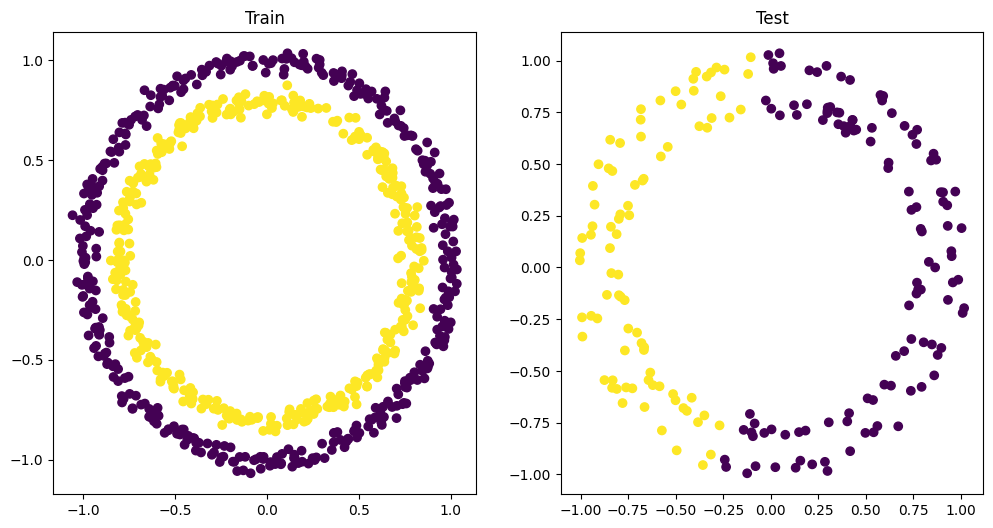

In [8]:
# plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plt.scatter(X_train.cpu()[:, 0], X_train.cpu()[:, 1], c=y_train.cpu())
plt.subplot(1, 2, 2)
plt.title("Test")
plt.scatter(X_test.cpu()[:, 0], X_test.cpu()[:, 1], c=y_pred.cpu())

### Non-Linear Model
- using non-linear activation function: ReLU

In [9]:
class MyModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # non-linear activation function

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))) # use ReLU in layer output

model_1 = MyModelV1().to(device)

# setup loss function
loss_fn = nn.BCEWithLogitsLoss() 

# setup the optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1) 

# put data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

set_seed(42)
epochs = 1000

# train model
for epoch in range(epochs):
    model_1.train() # train
    y_logits = model_1(X_train).squeeze() 
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Test ###
    model_1.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.71061, Acc: 50.00% | Test Loss: 0.70479, Test Acc: 50.00%
Epoch: 100 | Loss: 0.69279, Acc: 51.25% | Test Loss: 0.69140, Test Acc: 55.00%
Epoch: 200 | Loss: 0.69110, Acc: 52.38% | Test Loss: 0.69033, Test Acc: 56.50%
Epoch: 300 | Loss: 0.68927, Acc: 57.50% | Test Loss: 0.68916, Test Acc: 57.00%
Epoch: 400 | Loss: 0.68666, Acc: 62.75% | Test Loss: 0.68746, Test Acc: 57.00%
Epoch: 500 | Loss: 0.68265, Acc: 62.62% | Test Loss: 0.68485, Test Acc: 56.50%
Epoch: 600 | Loss: 0.67645, Acc: 63.25% | Test Loss: 0.68083, Test Acc: 56.50%
Epoch: 700 | Loss: 0.66745, Acc: 63.75% | Test Loss: 0.67425, Test Acc: 57.00%
Epoch: 800 | Loss: 0.65419, Acc: 65.12% | Test Loss: 0.66395, Test Acc: 58.00%
Epoch: 900 | Loss: 0.63261, Acc: 69.25% | Test Loss: 0.64448, Test Acc: 63.00%


In [10]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.1145, -0.3767],
                      [-0.3033,  0.0513],
                      [-0.1755, -0.3814],
                      [-0.3841, -0.8239],
                      [ 0.0192, -0.8603],
                      [-0.0786, -0.1983],
                      [-1.0175,  0.7653],
                      [ 0.2269, -0.0279],
                      [ 0.2063,  0.2050],
                      [ 1.0904,  0.7348]], device='mps:0')),
             ('layer_1.bias',
              tensor([-0.5207,  0.1179,  0.5211,  0.0813, -0.0135, -0.5198, -0.3547,  0.3133,
                      -0.0820, -0.2775], device='mps:0')),
             ('layer_2.weight',
              tensor([[ 0.1564,  0.1263,  0.2254, -0.2210, -0.1194,  0.1355, -0.4115,  0.2657,
                       -0.2262, -0.2973],
                      [ 0.2470, -0.0314,  0.0912,  0.0424, -0.0635, -0.0368, -0.0173, -0.1006,
                       -0.1403, -0.1153],
                      [ 0.2444,  0.0579,

In [11]:
# make predictions
model_1.eval()
with torch.inference_mode():
    y_pred = torch.round(torch.sigmoid(model_1(X_test))).squeeze()

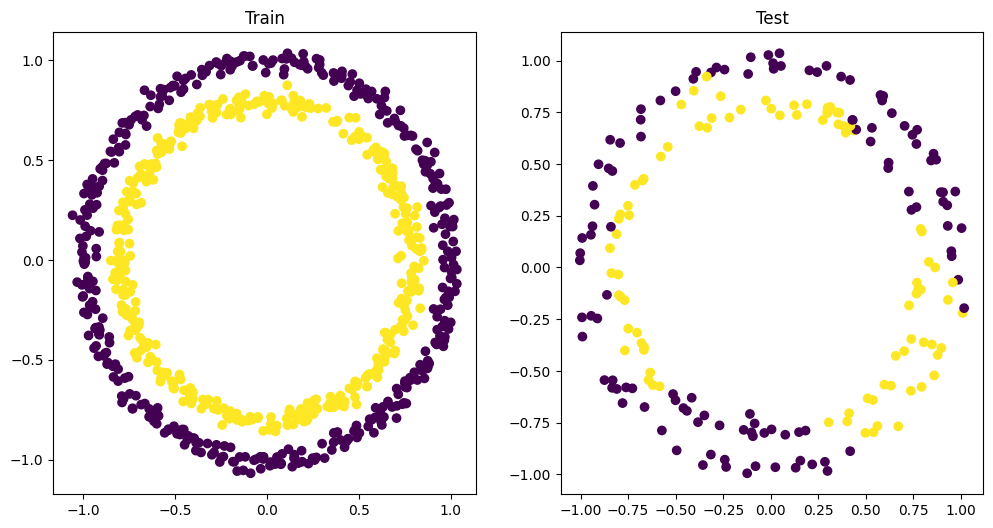

In [12]:
# plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plt.scatter(X_train.cpu()[:, 0], X_train.cpu()[:, 1], c=y_train.cpu())
plt.subplot(1, 2, 2)
plt.title("Test")
plt.scatter(X_test.cpu()[:, 0], X_test.cpu()[:, 1], c=y_pred.cpu())